# T021 ·  One-Hot Encoding

Developed in the CADD seminar 2020, Volkamer Lab, Charité/FU Berlin 

Authors :

- Sakshi Misra, CADD seminar 2020, Charité/FU Berlin
- Talia B. Kimber, 2020, [Volkamer lab](https://volkamerlab.org), Charité
- Yonghui Chen, 2020, [Volkamer lab](https://volkamerlab.org), Charité
- Andrea Volkamer, 2020, [Volkamer lab](https://volkamerlab.org), Charité

## Aim of this talktorial

The aim of the talktorial is to perform one-hot encoding of SMILES structures on a subset of the ChEMBL dataset to gain a deeper understanding on the one-hot encoding concept and why it is useful as a pre-processing step in various machine learning algorithms. 

<div style="text-align: center;">
<img src="images/logo.PNG" width="200" align='center'>
</div>

*Figure 1* : One-hot encoding in python. The figure is taken from the [blogpost](https://towardsdatascience.com/learning-one-hot-encoding-in-python-the-easy-way-665010457ad9).

### Contents in *Theory*

- Molecular data and representation
    - ChEMBL database
    - SMILES structures and rules
- What is categorical data?
     - What is the problem with categorical data?
     - How to convert categorical data to numerical data?
- The One-Hot Encoding concept
     - Why using one-hot encoding?
     - Example of one-hot encoding
     - Advantages of one-hot encoding
     - Disadvantages of one-hot encoding
- Other similar transformation: Integer encoding (label encoder)
- Difference between label and one-hot encoding
- Padding
- Further readings

### Contents in *Practical*

- Import necessary packages
- Read data
- Process data
     - Double digit replacement
     - Compute longest (& shortest) smiles
- Python implementation
     - One-hot encode (padding=True)
     - Visualization
          - Shortest smiles
          - Longest smiles 
- Supplementary material or other implementations 
   - Scikit learn implementation
   - Keras implementation

## References

- Theoretical background:
     - ChEMBL database: "The ChEMBL bioactivity database: an update." ([<i>Nucleic acids research<i> (2014), <b>42.D1</b>, D1083-D1090](https://doi.org/10.1093/nar/gkt1031))
     - Blogpost: Jason Brownlee, *How to One Hot Encode Sequence Data in Python*, [Machine Learning Mastery, accessed November 9th, 2020](https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/).
     - Blogpost: Krishna Kumar Mahto, *One-Hot-Encoding, Multicollinearity and the Dummy Variable Trap*, towardsdatascience, Available from [one-hot-encoding-multicollinearity](https://towardsdatascience.com/one-hot-encoding-multicollinearity-and-the-dummy-variable-trap-b5840be3c41a/), accessed July 8th, 2019.
     - Blogpost: Chris, *What is padding in a neural network?*, MACHINECURVE, Available from [Padding](https://www.machinecurve.com/index.php/2020/02/07/what-is-padding-in-a-neural-network/#:~:text=Padding%20avoids%20the%20loss%20of%20spatial%20dimensions,-Sometimes%2C%20however%2C%20you&text=You%20need%20the%20output%20images,in%20order%20to%20generate%20them.), accessed February 7th, 2020
     

- Packages and functions:
     - [**rdkit**](https://www.rdkit.org/docs/GettingStartedInPython.html): Greg Landrum,  *RDKit Documentation*, [PDF](https://buildmedia.readthedocs.org/media/pdf/rdkit/latest/rdkit.pdf), Release on 2019.09.1.
     - [**scikit-learn**](https://scikit-learn.org/stable/): 
        - [Scikit-learn: Machine Learning in Python](https://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html), Pedregosa *et al.*, JMLR 12, pp. 2825-2830, 2011.
        - Jiangang Hao, et al. "A Review of Scikit-learn Package in Python Programming Language." [*Journal of Education and Behavioral Statistics* **Volume: 44 issue: 3** (2019), page(s): 348-361](https://doi.org/10.3102/1076998619832248)
     - [**keras**](https://keras.io/): Book chapter: "An Introduction to Deep Learning and Keras" in [*Learn Keras for Deep Neural Networks* (2019), **page(s):1-16**](https://doi.org/10.1007/978-1-4842-4240-7).
     - [**Matplotlib**](https://matplotlib.org/)
     - [**timeit**](https://docs.python.org/3/library/timeit.html)
     - `smiles encoder` function: Blogpost by iwatobipen, *encode and decode SMILES strings* , [Wordpress, accessed November 9th, 2020](https://iwatobipen.wordpress.com/2017/01/22/encode-and-decode-smiles-strings/)

## Theory

### Molecular data and representation

#### ChEMBL database

- [ChEMBL](https://www.ebi.ac.uk/chembl/) is an open large-scale bioactivity database, containing molecules with drug-like properties. 
- Recent release 17 contains information extracted from  more than 51,000 publications, together with bioactivity   data sets from 18 other sources (depositors and databases). In total, there are now more than 1.3 million distinct compound structures and 12 million bioactivity data points.
- It is maintained by [European Bioinformatics Institute](https://en.wikipedia.org/wiki/European_Bioinformatics_Institute).


#### SMILES structures and rules
- [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) (Simplified Molecular Input Line Entry System) notation is a chemical notation that allows a user to represent a chemical structure of a molecule in a linear way that can be read by the computer (see "Modern Aspects of the Smiles Rearrangement" (2017), [*Chemistry A European Journal*, **Volume23, Issue38**, 8992-9008](https://doi.org/10.1002/chem.201700353) for further information).
- It contains a sequence of letters, numbers and characters that specify a molecule's atoms, their connectivity, bond order and chirality.

**Some SMILES specification rules**

- **Atoms** - are represented by their atomic symbols. Also metal atoms are represented with symbols in square bracket, e.g. Gold `[Au]`.
- **Bonds** - single, double and triple bonds are represented by symbols `-`, `=` and `#` respectively. Single bonds are the default and therefore do not need to be specified. 
- **Aromaticity** - While atomic symbols are generally used in upper case, such as C, O, S and N; to specify aromatic atoms lower case symbols are used instead, such as 'c', 'o', 's' and 'n'. Sometimes implicit bonds in rings (alternating `=` and `-`) are also used to describe aromatic atoms such as C1=CC=CC=C1.
- **Rings** - SMILES allows a user to identify ring structures by using numbers to identify the opening and closing ring atom. For example, in `C1CCCCC1`, the first carbon has a number '1' which connects by a single bond with the last carbon which also has a number '1'. The resulting structure is cyclohexane.
- **Branches** - are specified by enclosing them in parentheses, and can be nested or arranged. For example, 2-Propanol is represented by `CC(O)C`.

### What is categorical data?
Categorical data are variables that contain labels rather than numeric values.
Some examples include:

- A “pet” variable with the values: “dog” and “cat“.
- A “color” variable with the values: “red“, “green” and “blue“.
- A “place” variable with the values: “first”, “second” and “third“.

#### What is the problem with categorical data?
Machine Learning is, after all, a bunch of mathematical operations translated to a computer via low-level programming languages. Computers are brilliant when dealing with numbers. So we must somehow convert our input data to numbers. 
There are many machine learning algorithms which cannot operate on categorical data directly so they must be converted to a numerical form so all our input variables and output variables will be numeric (see [**Blogpost**](https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/): Alakh Sethi, *One-Hot Encoding vs. Label Encoding using Scikit-Learn* , Analytics Vidya, accessed March 6th, 2020 for further information).

<div style="text-align: center;">
<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/03/external-content.duckduckgo.com_.jpeg" alt="Drawing" style="max-width: 500px; width:400%;"/>
</div>

*Figure 2*: Displays the categorical encoding required for computers to understand the input. The figure comes from this [blogpost](https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/).

#### How to convert categorical data to numerical data?
There are many ways to convert categorical values into numerical values. Each approach has its own positive and negative impact on the feature set. Hereby, two main methods will be the focus: `One-Hot` encoding and `Label` encoding.
Both of these encoders are part of the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) library (one of the most widely used Python libraries) and are used to convert text or categorical data into numerical data which the model expects and and can work with.

### The *One-Hot Encoding* concept
The one-hot encoding is a vector representation where all the elements of the vector are set to `0` except one, which has `1` as its value. For example, `[0 0 0 1 0 0]` is a one-hot vector.
Simply put, one-hot encoding, also known as binary encoding, is a binary representation of categorical variables as binary vectors. 

The figure shown below helps us gain an overall idea of the one-hot encoding concept. 



<div style="text-align: center;">
    <img src="images/OneHotEncoding.png" style="max-width: 500px; width:100%;" />
</div>


*Figure 3* : Displays the one-hot encoding of the toluene molecule. Figure taken from the article [<i>BMC Bioinformatics.</i> (2018), <b>19</b>,526](https://doi.org/10.1186/s12859-018-2523-5), more information can be found there.
 

Let us take a deeper look into the concept with the help of a simple example that will describe the basic concept of one-hot encoding, why it is useful and how one can approach it.

#### Why using one-hot encoding?
One-hot encoding allows the representation of categorical data to be more expressive.
It is difficult for many machine learning algorithms to work with categorical data directly that's why the label values which are categorical must be converted into numbers first as a preprocessing step. This is required for both input and output variables that are categorical.

We could also use an *integer encoding* directly. This may work for problems where there is a natural ordinal relationship between the categories, and in turn the integer values, such as labels for temperature ‘cold’, warm’, and ‘hot’.
There may be problems when there is no ordinal relationship and allowing the representation to lean on any such relationship by using integer encoding might be not useful to solve the problem. An example might be the labels ‘dog’ and ‘cat’.

#### Example of one-hot encoding
Let us take a look at a very simple example to understand this concept. Assume we have the “color” variable which has three labels `RED` , `BLUE` and `GREEN`.
All these labels must be converted into numeric form in order to work with our machine learning algorithm. This can be done by creating three new columns having all three labels and use `1` for the color of the respective label and `0` for the other colors as shown in Figure 4.


<div style="text-align: center;">
    <img src="images/OneHotEncoding_eg.png" style="max-width: 700px; width:200%;" />
</div>

*Figure 4* : The visual demonstration of one-hot encoding done on the variable "color". Figure taken from the article: "*Building a One Hot Encoding Layer with TensorFlow*", George Novack, [towardsdatascience](https://towardsdatascience.com/building-a-one-hot-encoding-layer-with-tensorflow-f907d686bf39), more details can be found there.

####  Advantages of one-hot encoding 
-  If the cardinality (the number of categories) of the categorical features is low (relative to the amount of data), one-hot encoding will work best.
-  One hot encoding has the advantage that the result is binary rather than ordinal and that everything sits in an orthogonal vector space.

####  Disadvantages of one-hot encoding 
-  Increase in dimensionality, after adding several columns based on categorical variables which may result in an increase in the computational cost.
- There is a high chance of multi-collinearity due to dummy variables which can affect the performance of our model.
-  One-hot encoding can result in increasing the [sparsity](https://en.wikipedia.org/wiki/Sparse_matrix) of a dataset (a sparse matrix is a matrix in which most of the elements are zero).

### Other similar transformation: Integer encoding (label encoder)

[Label Encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), or integer encoding, is a popular encoding technique for handling categorical variables and is easily reversible. In this technique, each label is assigned a unique integer based on alphabetical ordering, so that machines can work with it properly.
Machine learning algorithms can then decide in a better way on how labels must be operated on.
It is an important preprocessing step for the structured dataset in supervised learning.

**Example of integer encoding**

Let us take a similar example as above: we have a color variable and we can assign `red` as `0`, `green` as `1`, and `blue` as `2` as shown in Figure 5.



![OneHotEncoding Example](images/label_encoding_example.png)

*Figure 5* : The visual demonstration of label encoding done on the variable "color". Figure taken from the article: "*Know about Categorical Encoding, even New Ones!*", Ahmed Othmen, [towardsdatascience](https://towardsdatascience.com/know-about-categorical-encoding-even-new-ones-c266227b9cbd), more details can be found there.


### Difference between label and one-hot encoding

There is not much difference between these two encoding techniques, it mainly depends on the type of data and model we are using. For example if we have categorical features which are not ordinal (dog or cat) then we can use one-hot encoding. Label encoding works best with ordinal data like `Good=0, Better=1, Best=2`.
Also when there are more categorical variables then it might be good to choose label encoding just to avoid high memory consumption and sparsity.

### Padding 

**What is padding?**

Additionally, we will perform padding in the practical section which is used to add zeros on the resulted one-hot encoded matrix. There are different types of padding, we chose to performed zero padding in here. For more details, please refer to this [Blogpost](https://www.machinecurve.com/index.php/2020/02/07/what-is-padding-in-a-neural-network/#:~:text=Padding%20avoids%20the%20loss%20of%20spatial%20dimensions,-Sometimes%2C%20however%2C%20you&text=You%20need%20the%20output%20images,in%20order%20to%20generate%20them.).

**Why is it performed?**

Padding is performed to make the dimensions of the matrix equal or to say preserve the height and the width and don't have to worry too much about tensor dimensions when used as an input for the deep learning models.


**How is it performed?**

It can be performed by using the [numpy.pad](https://numpy.org/doc/stable/reference/generated/numpy.pad.html) function which takes several parameters like the `array` which needs to be padded, `pad_width` which is number of values added to the edges of each axis and `mode` which by default is 'constant'.

In this talktorial, *padding* is performed
- *implicitly*: when applying one-hot encoding using python implementation on the preprocessed data, where we have given the maximum length of the string as the parameter so that all the resulting one-hot encoded matrices are of the same dimension
- *explicitly*: under supplementary section where we apply one-hot encoding using *keras* and under two scenarios when using *scikit-learn*. Padding is performed
    - *before one-hot encoding* : In this scenario, a function is defined to first pad the label encoded characters of the SMILES string and then perform one-hot encoding using scikit-learn.
    - *after one-hot encoding*: Whereas in this scenario, a function was defined to one-hot encode all the SMILES string and then perform padding on the resulted one-hot encoded matrix.

Both of these paddings are performed to compare the time difference in achieving one-hot encoding when no padding is performed and when the padding is performed.

### Further readings

This section lists some resources for further reading:

- [What is one-hot encoding and when is it used in data science?](https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science)
- [Categorical encoding using Label-Encoding and One-Hot-Encoder](https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd#:~:text=One%2DHot%20Encoding%20in%20Python&text=OneHotEncoder%20from%20SciKit%20library%20only,apply%20OneHotEncoder%20on%20column%20Bridge_Types_Cat.)
- Hirohara, M., Saito, Y., Koda, Y. et al. Convolutional neural network based on SMILES representation of compounds for detecting chemical motif. [_BMC Bioinformatics_ **19**, 526 (2018)](https://doi.org/10.1186/s12859-018-2523-5)
- [How one can use matplotlib.pyplot.imshow() in Python](https://www.geeksforgeeks.org/matplotlib-pyplot-imshow-in-python/)

## Practical

### Import necessary packages

In [1]:
from pathlib import Path
from warnings import filterwarnings
from timeit import default_timer as timer

import pandas as pd
import numpy as np
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import keras
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

# Silence some expected warnings
filterwarnings("ignore")

In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Read data

Using the `pandas` library, we first load the subset of the ChEMBL dataset and draw the molecules using the `rdkit.draw` function. We then python implementations of `one-hot encoding` to the SMILES structures.

Let's load the data and quickly analyze its column values and check if there are any missing values:

In [3]:
df = pd.read_csv(DATA/'CHEMBL25_activities_EGFR.csv',
                 lineterminator='\n', index_col=0)  # NBVAL_CHECK_OUTPUT
df=df.reset_index(drop=True)

In [4]:
# Check the dimension and missing value of the data
print("Shape of dataframe : ", df.shape)
df.info()

Shape of dataframe :  (3906, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3906 entries, 0 to 3905
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   chembl_id         3906 non-null   object 
 1   IC50              3906 non-null   float64
 2   units             3906 non-null   object 
 3   canonical_smiles  3906 non-null   object 
            3906 non-null   float64
dtypes: float64(2), object(3)
memory usage: 152.7+ KB


In [5]:
# Look at the first 3 rows
df.head(3)  # NBVAL_CHECK_OUTPUT

,chembl_id,IC50,units,canonical_smiles,pIC50\r
0,CHEMBL207869,77.0,nM,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,7.113509
1,CHEMBL3940060,330.0,nM,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,6.481486
2,CHEMBL3678951,1.0,nM,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,9.000000


In [6]:
# select the columns which are necessary
df = df[['chembl_id', 'canonical_smiles']]

We can visualize the molecules with their ChEMBL ID using pandas tools and the `draw` method as shown below.

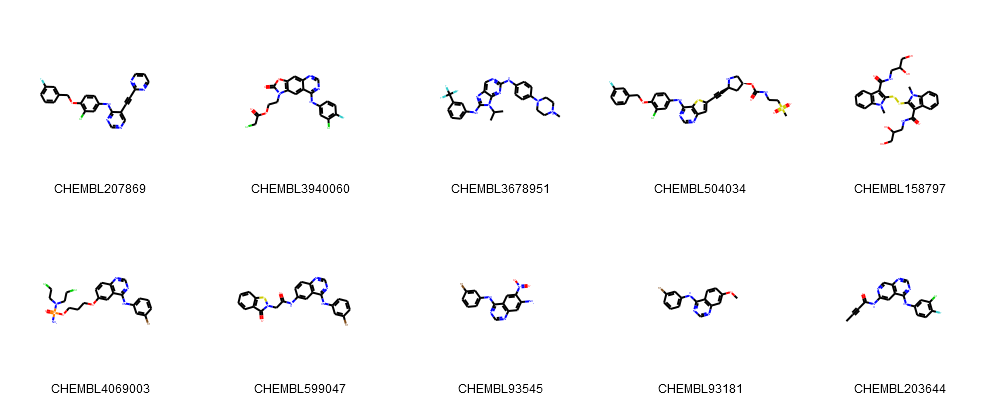

In [7]:
# Using pandas tools and the draw method
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='canonical_smiles', molCol='Mol2D' )
Draw.MolsToGridImage(list(df.Mol2D[0:10]),
                     legends=list(df.chembl_id[0:20]),
                     molsPerRow=5)  # NBVAL_CHECK_OUTPUT

### Process data

- SMILES strings could have unequal dimension since their string length might differ. For machine learning application, having equal dimension throughout the data set is required. In order to achieve this, we can first search for the SMILES string with the maximum length (e.g. [len()](https://www.geeksforgeeks.org/python-string-length-len/) method) and pass it as an argument in our function for all the strings.

- We searched for all the unique characters present in the SMILES data set which will allow us to remove the characters not present in the current data.

- As we know elements in the periodic table are represented by two characters, e.g. 'Cl' stands for chloride. This double-character phenomenon will be misinterpreted by the one hot encoding functions, i.e. it would split 'Cl' into two characters, namely 'C' and 'l', and that could lead to discrepancies, so searching for each unique character and encoding them may not be optimal. Hence, we suggest here to search for all double-character elements in our SMILES data set by comparing the atoms present in our strings with all the possible elements present in the periodic table and replacing all the two alphabetic elements with one character, for example changing 'Cl' to 'L'.

#### Double digit replacement

In [8]:
def assess_two_letter_elements(df):
    """
    Find the two letter elements in dataframe.

    Parameters
    ----------
    df : pandas.DataFrame
       Dataframe which requires preprocessing.

    Returns
    -------
    two_letter_elements : list
        List with found two letter elements
    """
    # Search for unique characters in our SMILES strings
    unique_chars = set(df.canonical_smiles.apply(list).sum())
    upper_chars = [] 
    lower_chars = [] 
    for entry in unique_chars:
        if entry.isalpha():
            if entry.isupper():
                upper_chars.append(entry)
            elif entry.islower():
                lower_chars.append(entry)
    print(f'Upper letter characters {upper_chars}')
    print(f'Lower letter characters {lower_chars}')
    
    # List of all possible periodic elements
    periodic_elements = ['Ac',
                         'Al', 'Am', 'Sb', 'Ar', 'As', 'At', 'Ba',
                         'Bk', 'Be', 'Bi', 'Bh', 'B', 'Br', 'Cd', 'Ca',
                         'Cf', 'C', 'Ce', 'Cs', 'Cl', 'Cr', 'Co', 'Cn',
                         'Cu', 'Cm', 'Ds', 'Db', 'Dy', 'Es', 'Er', 'Eu',
                         'Fm', 'Fl', 'F', 'Fr', 'Gd', 'Ga', 'Ge', 'Au',
                         'Hf', 'Hs', 'He', 'Ho', 'H', 'In', 'I', 'Ir',
                         'Fe', 'Kr', 'La', 'Lr', 'Pb', 'Li', 'Lv',
                         'Lu', 'Mg', 'Mn', 'Mt', 'Md', 'Hg', 'Mo',
                         'Mc', 'Nd', 'Ne', 'Np', 'Ni', 'Nh', 'Nb',
                         'N', 'No', 'Og', 'Os', 'O', 'Pd', 'P',
                         'Pt', 'Pu', 'Po', 'K', 'Pr', 'Pm', 'Pa',
                         'Ra', 'Rn', 'Re', 'Rh', 'Rg', 'Rb', 'Ru', 'Rf',
                         'Sm', 'Sc', 'Sg', 'Se', 'Si', 'Ag', 'Na',
                         'Sr', 'S', 'Ta', 'Tc', 'Te', 'Ts', 'Tb', 'Tl', 'Th',
                         'Tm', 'Sn',
                         'Ti', 'W', 'U', 'V', 'Xe', 'Yb', 'Y', 'Zn', 'Zr']

    # 'two_char_elements' is a list that contains two letter elements
    # which are valid when compared with all the possible periodic elements.
    two_char_elements = []
    for upper in upper_chars:
        for lower in lower_chars:
            ch = upper + lower
            if (ch in periodic_elements):
                two_char_elements.append(ch)

    # 'two_charc_elements_smiles' is a set that contains all the possible
    # two letter elements in our SMILES strings, that is specific to our dataset.
    two_char_elements_smiles = set()
    for char in two_char_elements:
        for index in range(len(df)):
            if (df['canonical_smiles'].iloc[index].find(char) != -1):
                two_char_elements_smiles.add(char)
    return(two_char_elements_smiles)

In [9]:
elements_found = assess_two_letter_elements(df)
print(f'Two letter elements found in data set: {elements_found}')

Upper letter characters ['O', 'N', 'I', 'P', 'S', 'B', 'H', 'F', 'C']
Lower letter characters ['n', 'r', 'c', 'l', 'e', 'o', 's']
Two letter elements found in data set: {'Cl', 'Se', 'Cn', 'Br', 'Sc'}


Based on this finding we defined our own dictionary for replacement. Note that
- We excluded *Sc* from replacement, since it is more likely that sulfur (S) and and aromatic carbon (c) are contained in a molecule than scandium (Sc).
- In isomeric SMILES `@` and `@@` are used to describe enantiomers, thus we also need to replace the latter by a one letter code.
- If you are working with a different data set, you may want to adapt the below mapping dictionary.

In [10]:
# Dictionary to replace the two letter elements found
replace_dict ={'Cl':'L', 'Br':'R' ,'Cn':'X' , 'Se':'Z' , '@@':'$'}

In [11]:
# Function used to create the preprocessed data
def preprocessing_data(df, replacement):
    """
    Preprocess the SMILES structures in a data set.

    Parameters
    ----------
    df : pandas.DataFrame
       Dataframe which requires preprocessing.
    replacement : dict
       Dictionary with mapping for replacement.
       
    Returns
    -------
    df : pandas.DataFrame
        Dataframe with new processed canonical SMILES column.
    unique_char : list
        List with unique characters present in SMILES.
    SMILES_maxlen : int
        Maximum length of SMILES string.
    """
    # Print warning if the dataset has a 'Sc' element
    for tmp_smiles in df.canonical_smiles:
        if (tmp_smiles.find('Sc') != -1): 
            print('**Warning**: "Sc" element is found in the dataset, since the element is rarely found '
                  'in the drugs so we are not converting  '
                  'it to single letter element, instead considering "S" '
                  'and "c" as seperate elements. ')
            break

    
    # Create a new column having processed canonical SMILES
    df['processed_canonical_smiles'] = ""

    # Replace the two letter elements found
    # with one character
    for index in range(len(df)):
        cur_smiles = df['canonical_smiles'].iloc[index]
        for key, value in replacement.items():
            cur_smiles = cur_smiles.replace(key,value)
        df['processed_canonical_smiles'].iloc[index] = cur_smiles
    
    # Calculate max length of the SMILES strings
    SMILES_maxlen = df["processed_canonical_smiles"].str.len().max()
    
    unique_char = set(df.processed_canonical_smiles.apply(list).sum())
    return unique_char, df, SMILES_maxlen

#### Compute longest (& shortest) smiles

In [12]:
# Index of the longest smile string
longest_smile = max(df["canonical_smiles"], key = len) 
longest_smile_index = df.canonical_smiles[df.canonical_smiles == longest_smile].index.tolist()
longest_smile_index

[2705]

In [13]:
# Index of the shortest smile string
shortest_smile = min(df["canonical_smiles"], key = len) 
shortest_smile_index = df.canonical_smiles[df.canonical_smiles == shortest_smile].index.tolist()
shortest_smile_index

[1176]

### Python implementation of one-hot encoding

#### One-hot encode (padding=True)

In [14]:
# Calling function
unique_char, df, SMILES_maxlen = preprocessing_data(df, replace_dict)

**Warning**: "Sc" element is found in the dataset, since the element is rarely found in the drugs so we are not converting  it to single letter element, instead considering "S" and "c" as seperate elements. 


In [15]:
# Function defined to create one-hot encoded matrix
def smiles_encoder(smiles, maxlen, uniquechar):
    """
    Function defined using all unique characters in our
    processed canonical smiles structures created
    from preprocessed function.

    Parameters
    ----------
    smiles : str
         SMILES data in string format.
    uniquechar : list
         list of unique characters in the string dataset.
    maxlen : int
         maximum length of the SMILES string.

    Returns
    -------
    smiles_matrix : ndarray
         One-hot encoded matrix of fixed shape
         (unique char in smiles, max smile length).
    """
    # create dictionary of the unique char dataset
    smi2index = dict((char, index) for index, char in enumerate(unique_char))
    # one hot encoding
    smiles_matrix = np.zeros((len(unique_char), maxlen))
    for index, char in enumerate(smiles):
        smiles_matrix[smi2index[char], index] = 1
    return smiles_matrix

,chembl_id,canonical_smiles,Mol2D,processed_canonical_smiles,unique_char_ohe_matrix
0,CHEMBL207869,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,,Lc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,CHEMBL3940060,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,,LCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(L)c(F)cc3)ncn...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,CHEMBL3678951,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."

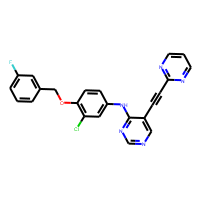
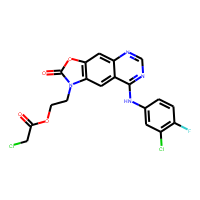
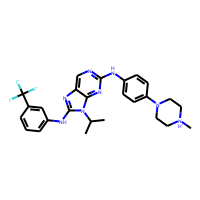

In [16]:
# Apply the function to the processed canonical SMILES strings
start = timer()
df['unique_char_ohe_matrix'] = df['processed_canonical_smiles'].apply(
                                  smiles_encoder, maxlen=SMILES_maxlen, 
                                  uniquechar=unique_char)
end = timer()
df.head(3)  # NBVAL_CHECK_OUTPUT

#### Visualization

`Matplotlib` is a plotting library for the python programming language and `Pyplot` is a state-based interface to a matplotlib module which provides a MATLAB-like interface.
The [imshow()](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.imshow.html) function in the pyplot module of the matplotlib library is used to display data as an image i.e. on a 2D space.

We now visualize our one-hot encoded matrix using `imshow()` by defining the `one_hot_matrix_plot` function as shown below.

In [18]:
def one_hot_matrix_plot(ohe_matrix, smiles_char, smiles):
    """
    Visualize one-hot encoded matrix
    using matplotlib imshow() function.

    Parameters
    ----------
    one_hot_matrix_plot : ndarray
       One-hot encoded (ohe) matrix of shape
       (`smiles_char`, `len(smiles)`).
    smiles_char : list
        list of all possible SMILES characters.
    smiles : string
        SMILES string of respective molecule        

    Returns
    ------
    None

    """
    im = plt.imshow(ohe_matrix, cmap='hot', interpolation='None')
    plt.xlabel('Length of SMILES string')
    plt.ylabel(f'Char in SMILES ({len(smiles_char)})')
    plt.title('Visualization of one-hot encoded matrix')
    plt.show()
    print('Shape of one-hot matrix : ', ohe_matrix.shape)
    print('Associated canonical SMILES: ', smiles)
    return None

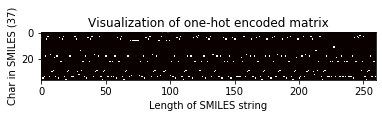

Shape of one-hot matrix :  (37, 260)
Associated canonical SMILES:  O=C(N[C@@H]1C(=O)N[C@H](CCC[NH3+])C(=O)N[C@@H]([C@H](CC)C)C(=O)N[C@H](Cc2ccccc2)C(=O)N[C@@H](Cc2[nH]cnc2)C(=O)N[C@H](CC(=O)[O-])C(=O)N[C@@H](CC(=O)N)C(=O)NCCCC1)[C@@H](NC(=O)[C@H](NC(=O)[C@@H](NC(=O)[C@H]1N=C([C@@H]([NH3+])[C@H](CC)C)SC1)CC(C)C)CCC(=O)[O-])[C@H](CC)C


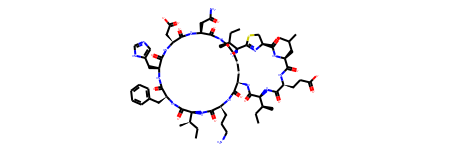

In [19]:
# Pass the index of the longest smile string to visualize the matrix
one_hot_matrix_plot(df.iloc[longest_smile_index[0]]['unique_char_ohe_matrix'], unique_char, 
                    longest_smile)  # NBVAL_CHECK_OUTPUT


# Draw the longest smile molecule
longest_smile_mol = Chem.MolFromSmiles(longest_smile)
longest_smile_mol

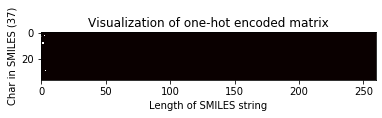

Shape of one-hot matrix :  (37, 260)
Associated canonical SMILES:  [Cl-]


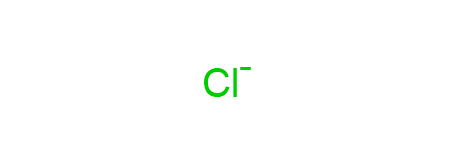

In [20]:
# Pass the index of the shortest smile string to visualize the matrix
one_hot_matrix_plot(df.iloc[shortest_smile_index[0]]['unique_char_ohe_matrix'], unique_char, 
                    shortest_smile)  # NBVAL_CHECK_OUTPUT

# Draw the shortest smile molecule
shortest_smile_mol = Chem.MolFromSmiles(shortest_smile)
shortest_smile_mol

From above, the matrix visualization was performed using matplotlib imshow() function, we can also visualize the entire matrix using the numpy.matrix function, e.g. the one-hot encoded matrix of the longest SMILES string as shown below.

In [21]:
# Print the some rows of the matrix for the longest smile
np.set_printoptions(threshold=np.inf)
subset=5
unique_char=list(unique_char)
print(f'First {subset} rows of the ohe matrix, representing the charcters {unique_char[0:subset]}\n')
print(np.matrix(df.iloc[longest_smile_index[0]]['unique_char_ohe_matrix'])[0:subset, :])

First 5 rows of the ohe matrix, representing the charcters ['n', 'R', '-', '[', 'O']

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

## Discussion 

OHE works best with sequence data
important preprocessing step

### Challenges 

There were several challenges faced during the task, for instance:

- Making equal dimensions of the one-hot encoded matrix.

- Replacing two letter elements with unique characters (note: the selected replacement might need to be extended for other datasets).

- After searching for two letter elements, we found a specific element `Sc` which is a metallic element. In our dataset both 'S' and 'c' elements are present individually as well. So if we would have replaced `Sc` with single a letter element then it might have effected our actual strings. So we assumed that since `Sc` is a metallic element and is rarely present in SMILES, we did not replace this element.

### Quiz

- Why is it required to have equal dimensions of the one-hot encoded matrix ?
- Is there any other way to pre-process the data ?
- How and which machine learning models can be applied on the above dataset ?

### Supplementary material 

If you are interested in other implementations of one-hot encoding, please keep reading this section. Here, we have used keras and scikit-learn implementation of one-hot encoding.

#### Scikit-learn implementation of one-hot encoding

Before implementing one hot encoding using scikit-learn, we have defined the functions named later_padding which adds horizontal and vertical padding to the given matrix and initial_padding which adds zeros to the character list after they are label encoded by using the numpy.pad function as discussed in the theory section.

It is defined here because it will be used as a boolean parameter (islaterpadding and isinitialpadding) later in the scikit-learn and keras implementations to choose if later padding or initial padding is required or not.

In [22]:
# Function to add padding after one-hot encoding
def later_padding(ohe_matrix, maxlen, uniquechar):
    """
    Add horizontal and vertical padding
    to the given matrix using numpy.pad() function.

    Parameters
    ----------
    ohe_matrix: ndarray
        Character array.
    smiles_max_len: int
        Maximum length of the SMILES string.
    unique_char: list
        List of unique characters in the string dataset.
            
    Returns
    -------
    padded_matrix: ndarray
           Padded one-hot encoded matrix of
           shape (unique char in smiles, max smile_length).
   """
    
    padded_matrix = np.pad(ohe_matrix, ((0, SMILES_maxlen-len(ohe_matrix)),
                                         (0, len(unique_char)-len(
                                          ohe_matrix[0]))), 'constant')
    return padded_matrix

In [23]:
# Function to add padding before one-hot encoding
# after label (integer) encoding
def initial_padding(smiles, maxlen):
    """
    Add zeroes to the list of characters 
    after integer encoding them

    Parameters
    ----------
    smiles : str
       SMILES string.
    maxlen: int
       Maximum length of the SMILES string

    Returns
    -------
    ndarray
      One-hot encoded matrix with intial padding of shape
      (unique char in smiles, max smile_length).
    """
    canonical_char = list(smiles)
    # perform padding on the list of characters
    canonical_char_padded = np.pad(canonical_char, (0,
                         maxlen-len(canonical_char)), 'constant')
    return canonical_char_padded

Now, we proceed with our second implementation of one-hot encoding from scikit-learn. We can use [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) from the `sklearn` library but it only takes numerical categorical values, hence any value of string type should be [label_encoded](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) first before one-hot encoded.


Running the functions below first give integer encoded SMILES of the labels and finally one-hot encode the SMILES structures.

By default, the OneHotEncoder class will return a more efficient sparse encoding which can be useful in some applications but in this case, we disabled the sparse return type by setting the `sparse=False` argument.

In [24]:
# Use Scikit-learn implementation of one-hot encoding
def sklearn_one_hot_encoded_matrix(smiles, islaterpadding, isinitialpadding):
    """
    Label and one-hot encodes the SMILES
    using sklearn LabelEncoder and OneHotEncoder implementation.
    
    Parameters
    ----------
    smiles : str
        SMILES string of a compound.
    islaterpadding : bool
        Paramater is `True` if `later_padding` is required,
        `False` otherwise.
    isinitialpadding : bool
        Paramater is `True` if `initial_padding` is required,
        `False` otherwise.
          
    Returns
    -------
    onehot_encoded : ndarray
        One-hot encoded matrix of shape
        (chars in individual SMILES, length of individual SMILES).
    """
    # Integer encoding
    canonical_char = list(smiles)
    label_encoder = LabelEncoder()
    # Fit_transform function is used to first fit the data and then transform it
    integer_encoded = label_encoder.fit_transform(canonical_char)
    
    if (isinitialpadding == True):
        integer_encoded = initial_padding(integer_encoded, SMILES_maxlen)
        
    # One-hot encoding
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    if (islaterpadding == True):
        onehot_encoded = later_padding(onehot_encoded, SMILES_maxlen, unique_char)
    
    onehot_encoded = onehot_encoded.transpose()
    
    if (isinitialpadding == True):
        row_padding = np.ndarray(shape=(len(unique_char)-len(onehot_encoded),
                                    SMILES_maxlen,))
        row_padding.fill(0)
        onehot_encoded = np.append(onehot_encoded, row_padding, axis=0)
    return onehot_encoded

#### Without padding (unequal dimension)

We can use the `sklearn_one_hot_encoded_matrix` function defined above to create the one-hot encoded matrix and no padding is perfomed, it will create unequal dimensions of the matrix because it will first label encode all the characters present in the SMILES strings (individually) and then one-hot encode them.

,chembl_id,canonical_smiles,Mol2D,processed_canonical_smiles,unique_char_ohe_matrix,sklearn_ohe_matrix_no_padding
0,CHEMBL207869,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,,Lc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,CHEMBL3940060,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,,LCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(L)c(F)cc3)ncn...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."

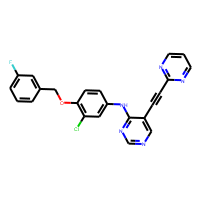
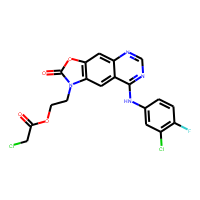

In [25]:
# Apply the function over the processed canonical SMILES strings
start = timer()
df['sklearn_ohe_matrix_no_padding'] = df['processed_canonical_smiles'].apply(
                                          sklearn_one_hot_encoded_matrix, 
                                          islaterpadding=False, 
                                          isinitialpadding=False)
end = timer()
df.head(2) # NBVAL_CHECK_OUTPUT

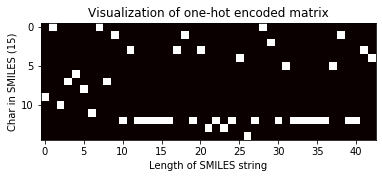

Shape of one-hot matrix :  (15, 43)
Associated canonical SMILES:  N([C@H](C)c1ccccc1)c1ncnc2oc(-c3ccccc3)cc12


In [26]:
index = 100
one_hot_matrix_plot(df.iloc[index]['sklearn_ohe_matrix_no_padding'],
                    df.iloc[index]['sklearn_ohe_matrix_no_padding'],
                    df.iloc[index]['processed_canonical_smiles'])  # NBVAL_CHECK_OUTPUT

#### With padding (equal dimension)
It can be either done after one-hot encoding is performed on the SMILES strings or before, meaning after we label encode the SMILES characters. We discuss both scenarios in the next sections.

##### Padding after one-hot encoding is performed

We simply pass **True** to the `islaterpadding` boolean parameter in `sklearn_one_hot_encoded_matrix` function as shown below to pad the matrix after one hot encoding is performed,

,chembl_id,canonical_smiles,Mol2D,processed_canonical_smiles,unique_char_ohe_matrix,sklearn_ohe_matrix_no_padding,sklearn_ohe_matrix_later_padding
0,CHEMBL207869,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,,Lc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,CHEMBL3940060,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,,LCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(L)c(F)cc3)ncn...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."

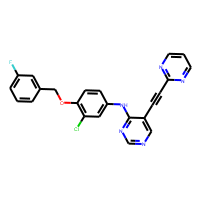
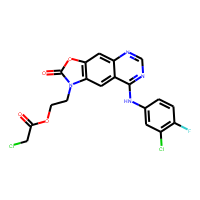

In [27]:
# Apply the function over the processed canonical SMILES strings
start = timer()
df['sklearn_ohe_matrix_later_padding'] = df['processed_canonical_smiles'].apply(
                                             sklearn_one_hot_encoded_matrix, 
                                             islaterpadding=True, isinitialpadding=False)
end = timer()
df.head(2) # NBVAL_CHECK_OUTPUT

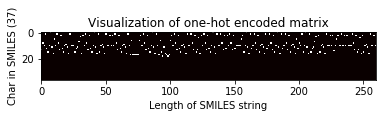

Shape of one-hot matrix :  (37, 260)
Associated canonical SMILES:  O=C(N[C$H]1C(=O)N[C@H](CCC[NH3+])C(=O)N[C$H]([C@H](CC)C)C(=O)N[C@H](Cc2ccccc2)C(=O)N[C$H](Cc2[nH]cnc2)C(=O)N[C@H](CC(=O)[O-])C(=O)N[C$H](CC(=O)N)C(=O)NCCCC1)[C$H](NC(=O)[C@H](NC(=O)[C$H](NC(=O)[C@H]1N=C([C$H]([NH3+])[C@H](CC)C)SC1)CC(C)C)CCC(=O)[O-])[C@H](CC)C


In [28]:
index = 2705
one_hot_matrix_plot(df.iloc[index]['sklearn_ohe_matrix_later_padding'],
                    unique_char,
                    df.iloc[index]['processed_canonical_smiles'])  # NBVAL_CHECK_OUTPUT

##### Padding before one-hot encoding is performed

In this case, padding is performed after label or integer encoding the list of SMILES characters by passing **True** to the `initial_padding` boolean parameter in `sklearn_one_hot_encoded_matrix` function.

,chembl_id,canonical_smiles,Mol2D,processed_canonical_smiles,unique_char_ohe_matrix,sklearn_ohe_matrix_no_padding,sklearn_ohe_matrix_later_padding,sklearn_ohe_matrix_initial_padding
0,CHEMBL207869,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,,Lc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,CHEMBL3940060,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,,LCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(L)c(F)cc3)ncn...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."

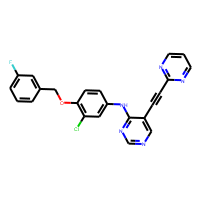
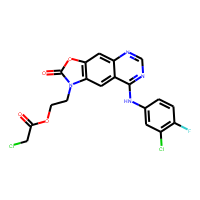

In [29]:
# Apply the function over the processed canonical SMILES strings
start = timer()
df['sklearn_ohe_matrix_initial_padding'] = df['processed_canonical_smiles'].apply(
                                               sklearn_one_hot_encoded_matrix, 
                                               islaterpadding=False, 
                                               isinitialpadding=True)

end = timer()
df.head(2)

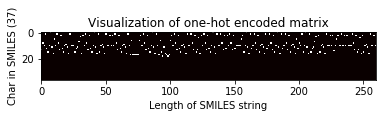

Shape of one-hot matrix :  (37, 260)
Associated canonical SMILES:  O=C(N[C$H]1C(=O)N[C@H](CCC[NH3+])C(=O)N[C$H]([C@H](CC)C)C(=O)N[C@H](Cc2ccccc2)C(=O)N[C$H](Cc2[nH]cnc2)C(=O)N[C@H](CC(=O)[O-])C(=O)N[C$H](CC(=O)N)C(=O)NCCCC1)[C$H](NC(=O)[C@H](NC(=O)[C$H](NC(=O)[C@H]1N=C([C$H]([NH3+])[C@H](CC)C)SC1)CC(C)C)CCC(=O)[O-])[C@H](CC)C


In [30]:
index = 2705
one_hot_matrix_plot(df.iloc[index]['sklearn_ohe_matrix_later_padding'],
                    unique_char,
                    df.iloc[index]['processed_canonical_smiles'])  # NBVAL_CHECK_OUTPUT

#### Keras implementation of one-hot encoding

Keras is also a very powerful and intensively used library, especially employed in deep learning tasks. 
There may be a case where we have sequences or strings that are already integer encoded, then we can use the function called [to_categorical()](https://keras.io/api/utils/), provided by the keras library, to one-hot encode integer data directly, otherwise we can use [Tokenizer](https://keras.io/api/preprocessing/text/) to first integer encode the string data and then use `to_categorical` function to one-hot encode the string data.

In [31]:
# Use keras implementation of one-hot encoding
def keras_one_hot_encoded_matrix(smiles, islaterpadding, maxlen, uniquechar):
    """
    One-hot encodes the SMILES using keras
    implementation.
    
    Parameters
    ----------
    canonical_char : array
        Canonical character array.
    islaterpadding : bool
        The paramater is `True` if later_padding is required,
        `False` otherwise.
    maxlen: int
        Maximum length of the SMILES string.
    uniquechar: list
        List of unique characters in the string dataset.
        
    Returns
    -------
    encoded : ndarray
        One-hot encoded matrix of shape
        (chars in SMILES, length of SMILES).
    """
   
    # Integer encoding using Tokenizer
    input = smiles
    tokenizer = Tokenizer(char_level=True)
    tokenizer.fit_on_texts([input])
    integer_encoded = tokenizer.texts_to_sequences([input])[0]
    
    # One-hot encoding using to_categorical function
    encoded = to_categorical(integer_encoded)
    if (islaterpadding == True):
        encoded = later_padding(encoded, SMILES_maxlen,unique_char)
    encoded = encoded.transpose()
    return encoded

Next, we will implement two scenarios, 

- one, when there is no later padding performed which will result in unequal dimensions of the produced one-hot encoded matrix and 
- the other, where later padding will be performed by passing `True` to the boolean parameter `islaterpadding` in the `keras_one_hot_encoded_matrix` function.

#### Without padding (unequal dimension)

,chembl_id,canonical_smiles,Mol2D,processed_canonical_smiles,unique_char_ohe_matrix,sklearn_ohe_matrix_no_padding,sklearn_ohe_matrix_later_padding,sklearn_ohe_matrix_initial_padding,keras_ohe_matrix_without_padding
0,CHEMBL207869,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,,Lc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,CHEMBL3940060,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,,LCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(L)c(F)cc3)ncn...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."

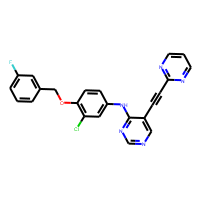
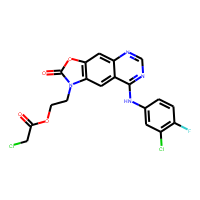

In [32]:
# Apply the function over the processed canonical SMILES strings
start = timer()
df['keras_ohe_matrix_without_padding'] = df['processed_canonical_smiles'].apply(
                                            keras_one_hot_encoded_matrix, 
                                            maxlen = SMILES_maxlen, 
                                            uniquechar = unique_char, 
                                            islaterpadding=False)
end = timer()
df.head(2)

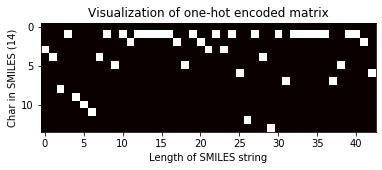

Shape of one-hot matrix :  (14, 43)
Associated canonical SMILES:  N([C@H](C)c1ccccc1)c1ncnc2oc(-c3ccccc3)cc12


In [33]:
# choose index of the compound for which the OHE matrix is visualised 
index = 100
one_hot_matrix_plot(df.iloc[index]['keras_ohe_matrix_without_padding'],
                    df.iloc[index]['keras_ohe_matrix_without_padding'],
                    df.iloc[index]['processed_canonical_smiles'])  # NBVAL_CHECK_OUTPUT

#### With padding (equal dimension)

,chembl_id,canonical_smiles,Mol2D,processed_canonical_smiles,unique_char_ohe_matrix,sklearn_ohe_matrix_no_padding,sklearn_ohe_matrix_later_padding,sklearn_ohe_matrix_initial_padding,keras_ohe_matrix_without_padding,keras_ohe_matrix_padding
0,CHEMBL207869,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,,Lc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,CHEMBL3940060,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,,LCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(L)c(F)cc3)ncn...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."

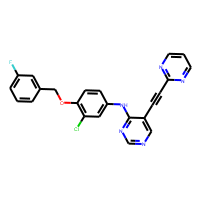
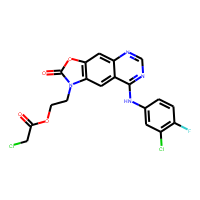

In [34]:
# Apply the function over the Processed_canonical_smiles strings
start = timer()
df['keras_ohe_matrix_padding'] = df['processed_canonical_smiles'].apply(
                                    keras_one_hot_encoded_matrix, 
                                    maxlen = SMILES_maxlen,
                                    uniquechar = unique_char, 
                                    islaterpadding=True)
end = timer()
df.head(2)

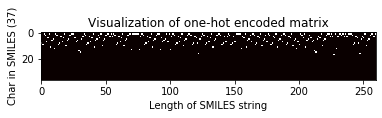

Shape of one-hot matrix :  (37, 260)
Associated canonical SMILES:  O=C(N[C$H]1C(=O)N[C@H](CCC[NH3+])C(=O)N[C$H]([C@H](CC)C)C(=O)N[C@H](Cc2ccccc2)C(=O)N[C$H](Cc2[nH]cnc2)C(=O)N[C@H](CC(=O)[O-])C(=O)N[C$H](CC(=O)N)C(=O)NCCCC1)[C$H](NC(=O)[C@H](NC(=O)[C$H](NC(=O)[C@H]1N=C([C$H]([NH3+])[C@H](CC)C)SC1)CC(C)C)CCC(=O)[O-])[C@H](CC)C


In [35]:
# choose index of the compound for which the OHE matrix is visualised 
index = 2705
one_hot_matrix_plot(df.iloc[index]['keras_ohe_matrix_padding'],
                    unique_char,
                    df.iloc[index]['processed_canonical_smiles'])  # NBVAL_CHECK_OUTPUT